In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# from importlib import reload
# reload(dc)
import data_cleaner as dc  # self-writtten python functions

pd.set_option('display.max_rows', 500)  # let pd.df display() 500 rows
pd.set_option('display.max_columns', 500)

### Import data

- wave ADNI1, ADNIGO as training

- wave ADNI2, ADNI3 as testing

In [9]:
x_train = pd.read_csv("../clean_data/mci_wv1go_imp.csv")    
x_test = pd.read_csv("../clean_data/mci_wv23_imp.csv")
y_train = x_train.pop("progress")
y_test = x_test.pop("progress")
errs = pd.DataFrame(columns=[0,1,2])

### Base model Training

- use a simple KNN imputation for logistic regression & linear SVM

- ensembling learning methods use their default imputations

In [10]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
mod_log = LogisticRegression(penalty=None, max_iter=500)
mod_log.fit(x_train, y_train)
pred_train = mod_log.predict(x_train) 
pred_test = mod_log.predict(x_test) 
errs = pd.concat([errs, pd.DataFrame([["Logistic", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [11]:
from sklearn.svm import SVC
mod_svm = Pipeline([
    ("scale", StandardScaler() ),
    ('model', SVC(kernel='linear', probability=True)),
])
mod_svm.fit(x_train, y_train)
pred_train = mod_svm.predict(x_train) 
pred_test = mod_svm.predict(x_test) 
errs = pd.concat([errs, pd.DataFrame([["SVM", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [12]:
# light gbm:
mod_lgb = lgb.LGBMClassifier()
mod_lgb.fit(x_train, y_train)
pred_train = mod_lgb.predict(x_train) 
pred_test = mod_lgb.predict(x_test) 
errs = pd.concat([errs, pd.DataFrame([["Light GBM", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [13]:
# xgboost:
mod_xgb = xgb.XGBClassifier()
mod_xgb.fit(x_train, y_train)
pred_train = mod_xgb.predict(x_train) 
pred_test = mod_xgb.predict(x_test) 
errs = pd.concat([errs, pd.DataFrame([["XGBoost", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [14]:
# catboost:
mod_cat = CatBoostClassifier(silent=True)
mod_cat.fit(x_train, y_train)
pred_train = mod_cat.predict(x_train) 
pred_test = mod_cat.predict(x_test) 
errs = pd.concat([errs, pd.DataFrame([["CatBoost", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [15]:
# GBM
mod_gbm = GradientBoostingClassifier()
mod_gbm.fit(x_train, y_train)
pred_train = mod_gbm.predict(x_train) 
pred_test = mod_gbm.predict(x_test) 
errs = pd.concat([errs, pd.DataFrame([["GBM", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [16]:
# rf
from sklearn.ensemble import RandomForestClassifier
mod_rf = RandomForestClassifier()
mod_rf.fit(x_train, y_train)
pred_train = mod_rf.predict(x_train) 
pred_test = mod_rf.predict(x_test)
errs = pd.concat([errs, pd.DataFrame([["RF", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

### Evaluation

- Overfitting issue in ensemble methods

- Baseline Performance: > 0.8

- Catboost > lightGBM > XGBoost > GBM > SVM > logistic

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

,Method,train,test
0,Logistic,0.840054,0.808
0,SVM,0.885753,0.916
0,Light GBM,1.000000,0.952
0,XGBoost,1.000000,0.948
0,CatBoost,0.998656,0.936
0,GBM,0.979839,0.920
0,RF,1.000000,0.956


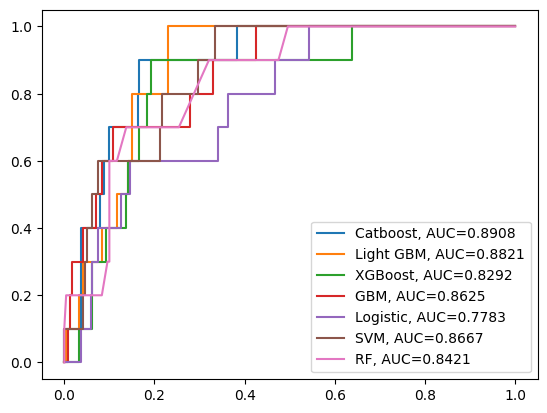

In [18]:
errs.columns = ["Method", "train", "test"]
display(errs)
plt.figure(0).clf()
# Catboost:
y_pred = mod_cat.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Catboost, AUC="+str(auc))

# light gbm:
y_pred = mod_lgb.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Light GBM, AUC="+str(auc))

# xgboost:
y_pred = mod_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

# gbm:
y_pred = mod_gbm.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="GBM, AUC="+str(auc))

# Logistic:
y_pred = mod_log.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))

# SVM:
y_pred = mod_svm.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))

# RF:
y_pred = mod_rf.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))

plt.legend()

In [ ]:
# rf
from sklearn.ensemble import RandomForestClassifier
mod_rf = RandomForestClassifier()
mod_rf.fit(x_train, y_train)
pred_train = mod_rf.predict(x_train) 
pred_test = mod_rf.predict(x_test)
errs = pd.concat([errs, pd.DataFrame([["RF", np.mean(pred_train == y_train), 
                         np.mean(pred_test == y_test)]]) ])

In [19]:
# save the outcome of logistic regression, GBM, and SVM
def save_res(model, nm):
    res = {'train_pred':model.predict(x_train), 
           'train_prob':model.predict_proba(x_train)[:,1],
           'test_pred':model.predict(x_test), 
           'test_prob':model.predict_proba(x_test)[:,1]}
    dc.save_py(res, f"output/{nm}")


In [20]:
models = [mod_log, mod_svm, mod_rf, mod_gbm]
nms = ["result_"+nm+"_imp" for nm in ["log", "svm", "rf", "gbm"]]

In [21]:
# for i in range(4):
#     save_res(models[i], nms[i])